In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [2]:
df = pd.DataFrame()

In [3]:
pe_nor = pd.read_csv('normal_pe.csv')
pe_mal = pd.read_csv('malware_pe.csv')
pe_all = pd.concat([pe_nor, pe_mal])  # 998 x 72

print(pe_all.shape)

(998, 72)


In [4]:
print ("[*] Before Filtering NA values: ", pe_all.shape)
NA_values = pe_all.isnull().values.sum()
print ("[*] Missing Values: ", NA_values)
pe_all = pe_all.dropna()
print ("[*] After Filtering NA values: ", pe_all.shape)

[*] Before Filtering NA values:  (998, 72)
[*] Missing Values:  610
[*] After Filtering NA values:  (937, 72)


In [23]:
pe_all['OH_DLLchar9'].unique()

array([0, 1])

In [5]:
pe_all['OH_DLLchar9'] = pd.to_numeric(pe_all['OH_DLLchar9'], errors='coerce')

In [6]:
pe_all_tmp = pe_all  # 데이터 백업
pe_all = pe_all.drop(['filename', 'MD5', 'packer_type'], 1) # 파일이름, MD5, packer_type 열 제거

Y = pe_all['class'] # 카테고리 열을 별도로 추출
X = pe_all.drop('class', 1) # 카테고리 열 제거
Y_bak = Y # 뒤에서 진행할 특징 선택 작업을 위해 데이터 백업

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
model = XGBClassifier(max_depth=7)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

acc = accuracy_score(y_test, predictions)
print(acc)

# max_depth = 1, acc = 0.9202127659574468
# max_depth = 2, acc = 0.9308510638297872
# max_depth = 3, acc = 0.9308510638297872
# max_depth = 4, acc = 0.9414893617021277
# max_depth = 5, acc = 0.9308510638297872
# max_depth = 6, acc = 0.9414893617021277
# max_depth = 7, acc = 0.9521276595744681
# max_depth = 8, acc = 0.9521276595744681
# max_depth = 9, acc = 0.9521276595744681
# max_depth = 10, acc = 0.9414893617021277

0.9521276595744681


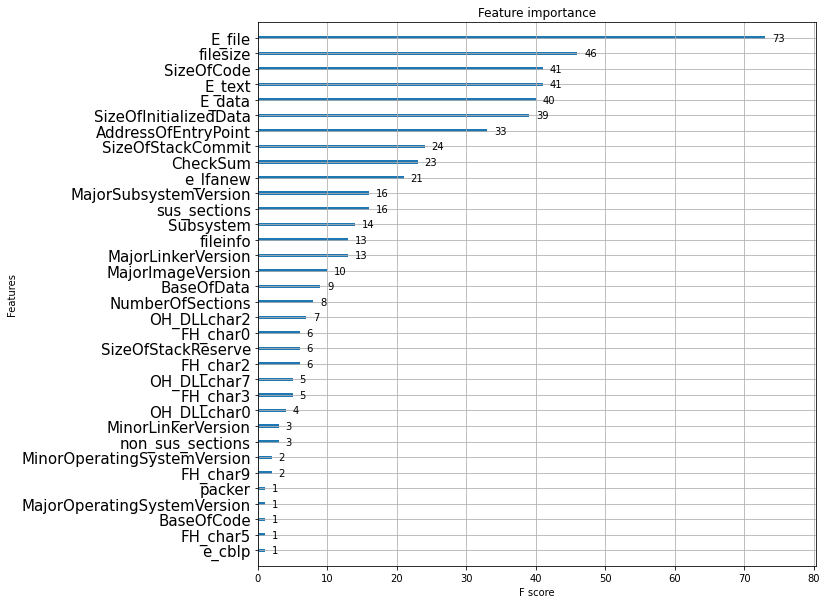

In [9]:
rcParams['figure.figsize'] = 10,10

plot_importance(model)

plt.yticks(fontsize=15)
plt.show()

In [10]:
pe_all['E_file']

0      6.053511
1      5.236077
2      7.999837
3      6.337480
4      7.971035
         ...   
493    7.293633
496    1.714031
497    7.741811
498    6.932769
499    7.144485
Name: E_file, Length: 937, dtype: float64

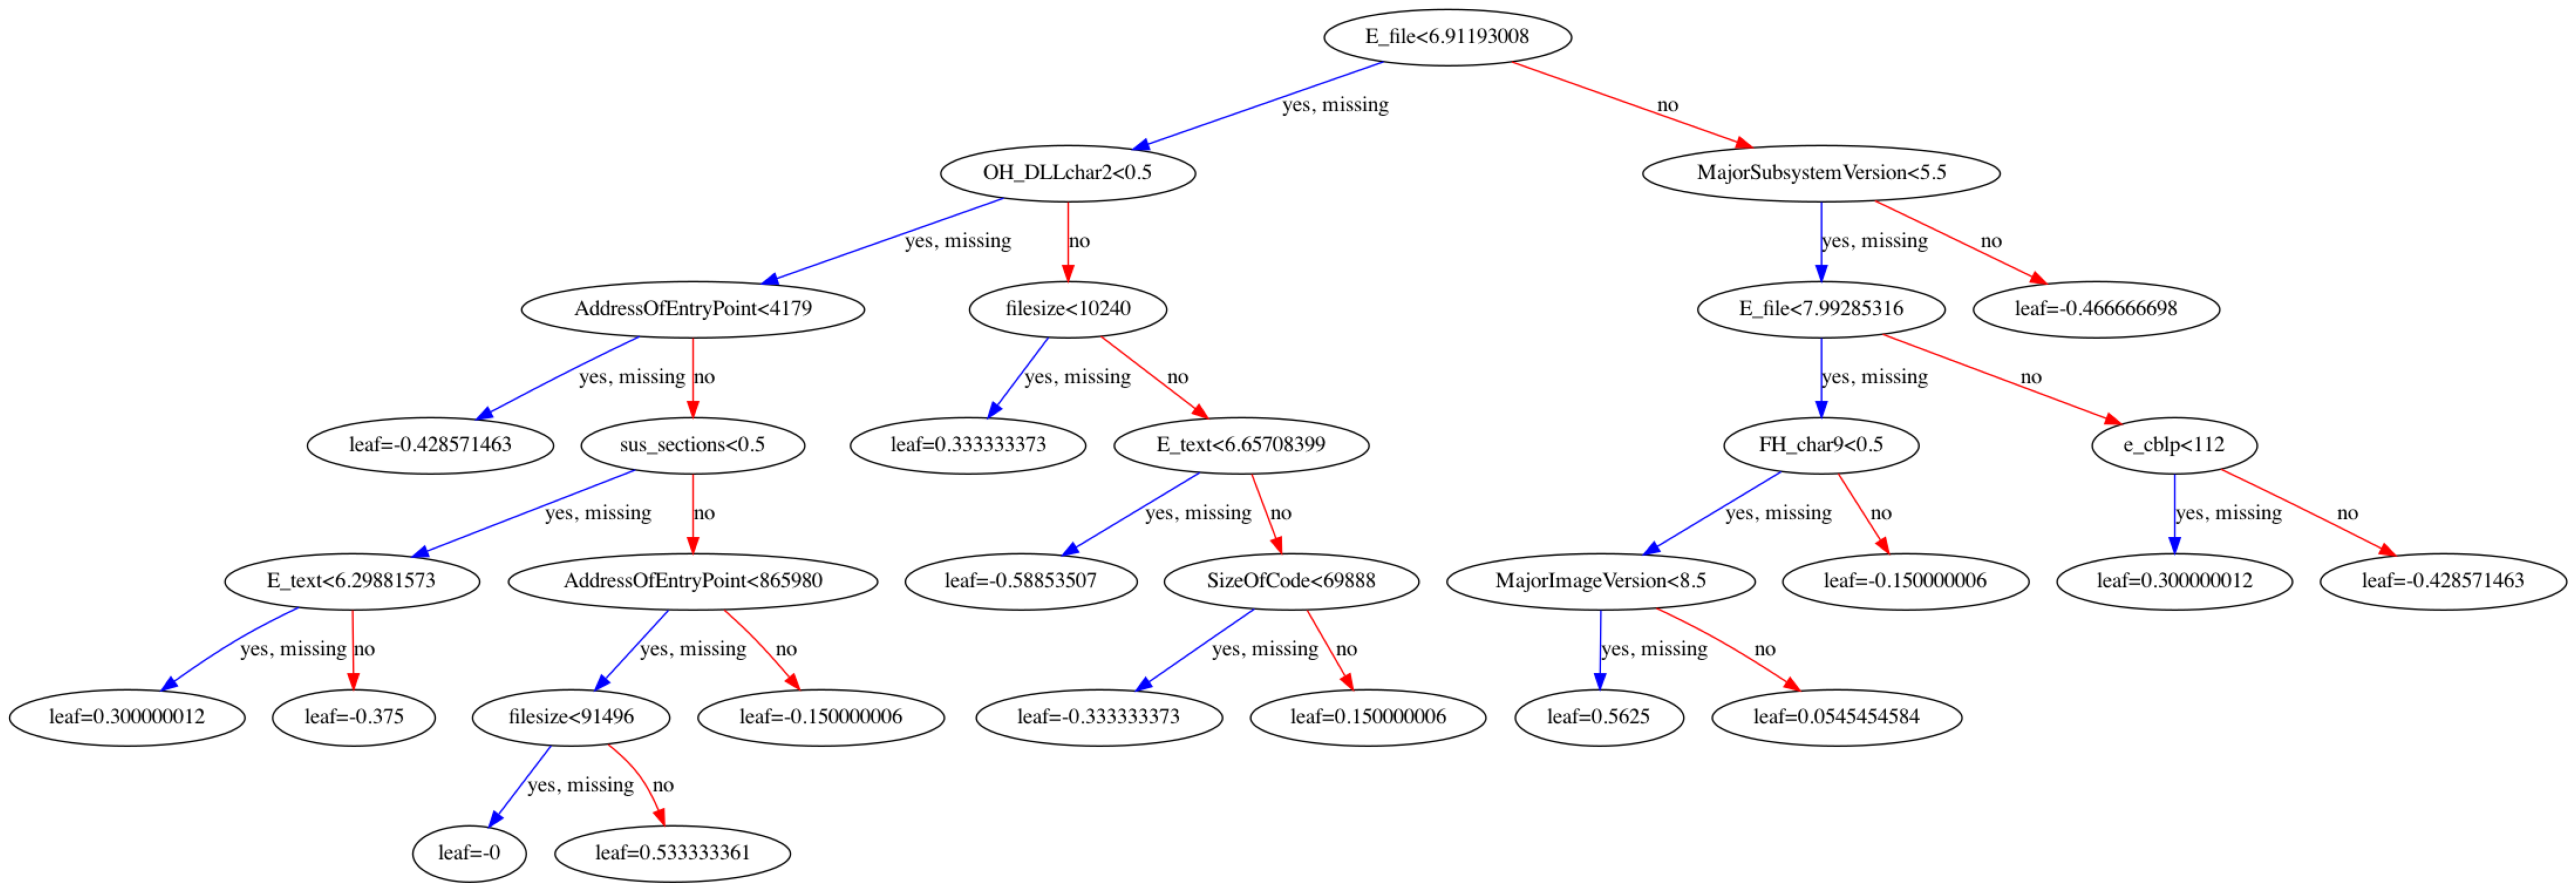

In [11]:
from xgboost import plot_tree

rcParams['figure.figsize'] = 100,200

plot_tree(model)
plt.show()

In [29]:
import shap

idx = 557

print(x_train.iloc[idx, :])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap.force_plot(explainer.expected_value,
          shap_values[idx, :],
          x_train.iloc[idx, :])

e_cblp           144.000000
e_cp               3.000000
e_cparhdr          4.000000
e_maxalloc     65535.000000
e_sp             184.000000
                  ...      
E_text             6.091994
E_data             1.088203
filesize      284160.000000
E_file             6.296901
fileinfo           0.000000
Name: 473, Length: 68, dtype: float64


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


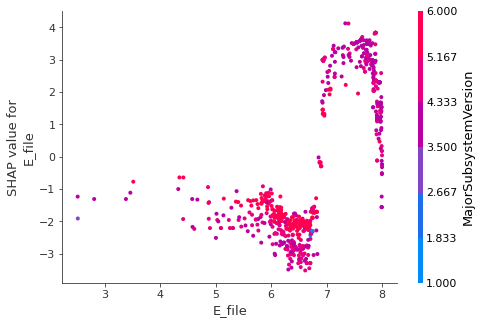

In [30]:
shap.dependence_plot("E_file", shap_values, x_train)

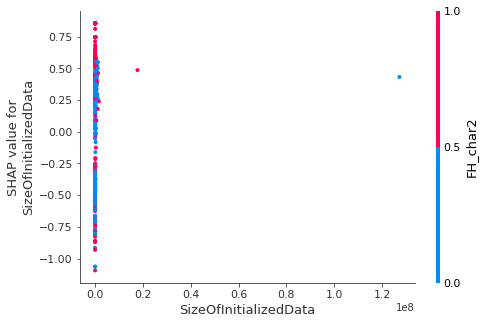

In [28]:
shap.dependence_plot("SizeOfInitializedData", shap_values, x_train)

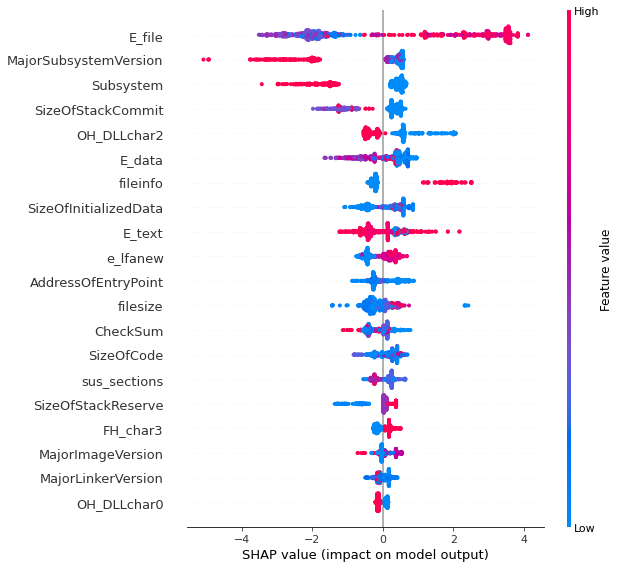

In [31]:
shap.summary_plot(shap_values, x_train)

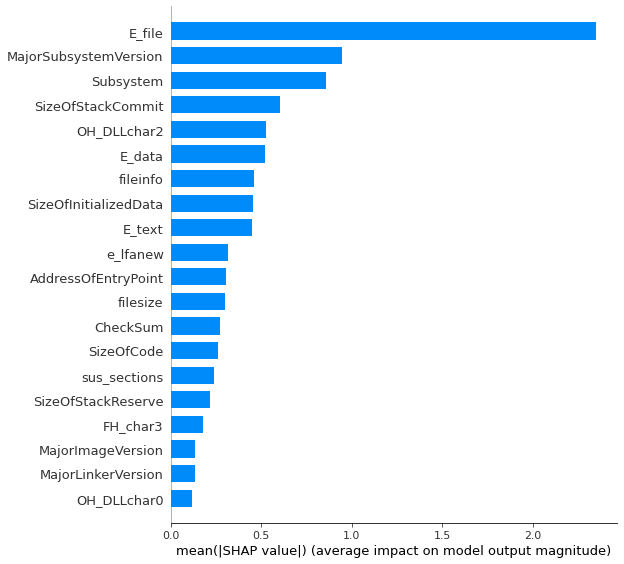

In [32]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [15]:
# hyper-parameter search
cv_params = {
    'max_depth': np.arange(1, 10, 1)
}

fix_params = {
    'booster':'gbtree',
    'objective':'binary:logistic',
}

csv = GridSearchCV(XGBClassifier(**fix_params),
                  cv_params,
                  scoring = 'precision',
                  cv = 5,
                  n_jobs=-1)

csv.fit(x_train, y_train)

print(csv.best_params_)

y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

#for parameter in csv.cv_results_["params"]:
#    print(parameter)

{'max_depth': 2}
0.9308510638297872


In [18]:
# hyper-parameter search
cv_params = {
    'learning_rate': np.arange(0.01, 0.9, 0.01),
    'n_estimators': np.arange(10, 500, 10),
    'reg_alpha': np.arange(0.01, 0.2, 0.01),
    'reg_lambda': np.arange(0.1, 0.9, 0.1),
}

fix_params = {
    'max_depth': 7,
    'booster':'gbtree',
    'objective':'binary:logistic',
}

csv = GridSearchCV(XGBClassifier(**fix_params),
                  cv_params,
                  scoring = 'precision',
                  cv=5,
                  n_jobs=-1)

csv.fit(x_train, y_train)

print(csv.best_params_)

y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

for parameter in csv.cv_result_["params"]:
    print(parameter)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

In [ ]:
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
tn = cm[0,0]

precision = tp/(tp+fp)
recall = tp/(tp+fn)
fallout = fp/(fp+tn)

print("Presion = {:.3f}".format(presion))
print("Recall = {:.3f}".format(recall))
print("Fallout = {:.3f}".format(fallout))
print("F1-score = {:.3f}".format(2*((precision*recall)/(presion+recall)))